In [107]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
from IPython.display import display
%matplotlib inline
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings("ignore")

### Разбор эксперимента.
 Аналитик из *генеральной совокупности* сформировал выборку из 5000 пользователей функцией **random**, сделал в получившейся выборке рассылку с уведомлением о подключении некоторой функции. Через некоторое время удалил из выборки неактивных пользователей. Далее аналитик решил протестировать гипотезу на двух группах о том, что при прочих равных, новая функция снижает средние издержки пользователей. По прошествию месяца добавил столбец delta – изменение месячных транспортных расходов(exp1 - exp0). После чего функцией **groupby** аналитик произвел анализ в разностях средних между тестовой и контрольной группами.

In [108]:
userlist = pd.read_csv('userlist.csv', index_col=0)
data = pd.read_csv('data.csv', index_col=0)

In [109]:
userlist.head()

,userID,group
1,3331,Y
2,1912,Y
3,3035,Y
4,916,Y
5,1920,Y


**Проверим что имеем**

In [110]:
# Функция первичного анализа данных
def df_info(df):
  print(df.info())
  display(df.head())
  display(df.describe().T)
  print('Пропущенные значения:')
  print(df.isna().sum())
  print('Дубликаты', df.duplicated().sum())

In [111]:
# Пользователи в эксперименте
df_info(userlist)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4699 entries, 1 to 4699
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userID  4699 non-null   int64 
 1   group   4699 non-null   object
dtypes: int64(1), object(1)
memory usage: 110.1+ KB
None


,userID,group
1,3331,Y
2,1912,Y
3,3035,Y
4,916,Y
5,1920,Y


,count,mean,std,min,25%,50%,75%,max
userID,4699.0,2350.0,1356.628787,1.0,1175.5,2350.0,3524.5,4699.0


Пропущенные значения:
userID    0
group     0
dtype: int64
Дубликаты 0


In [112]:
# массив с данными эксперимента
df_info(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4699 entries, 1 to 4699
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userID  4699 non-null   int64
 1   exp0    4699 non-null   int64
 2   exp1    4699 non-null   int64
 3   delta   4699 non-null   int64
dtypes: int64(4)
memory usage: 183.6 KB
None


,userID,exp0,exp1,delta
1,1824,2146,1935,-211
2,500,3636,3549,-87
3,1660,4198,4158,-40
4,3160,2388,2223,-165
5,2961,9524,9427,-97


,count,mean,std,min,25%,50%,75%,max
userID,4699.0,2350.000000,1356.628787,1.0,1175.5,2350.0,3524.5,4699.0
exp0,4699.0,4384.979357,2634.158041,579.0,2338.5,3815.0,5786.5,23436.0
exp1,4699.0,4256.875293,2625.620091,350.0,2223.5,3683.0,5642.5,23263.0
delta,4699.0,-128.104065,62.207323,-361.0,-168.0,-127.0,-87.0,100.0


Пропущенные значения:
userID    0
exp0      0
exp1      0
delta     0
dtype: int64
Дубликаты 0


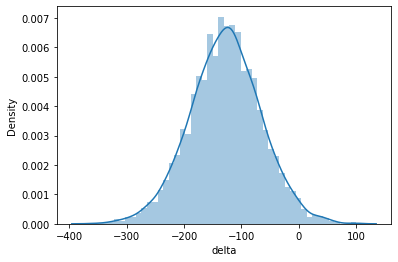

In [113]:
# Посмотрим на распределение изменения месячных расходов - нормальное
sns.distplot(data['delta']);

In [114]:
df=data.merge(userlist, on = 'userID', how='left')
df.head()

,userID,exp0,exp1,delta,group
0,1824,2146,1935,-211,Y
1,500,3636,3549,-87,N
2,1660,4198,4158,-40,N
3,3160,2388,2223,-165,Y
4,2961,9524,9427,-97,N


In [115]:
df.groupby(['group']).agg({'userID':'count', 'delta':'mean'})

,userID,delta
group,,
N,2664,-140.466592
Y,2035,-111.920393


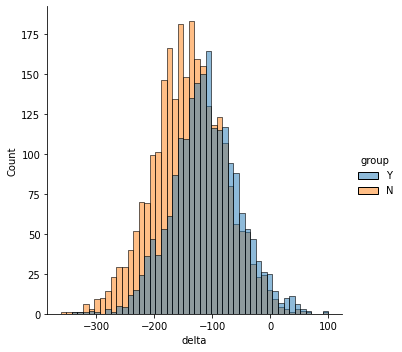

In [116]:
# Посмотрим на распределение издержек по группам - нормальное
sns.displot(x='delta', hue='group', data=df);

## Проверка гипотез

Предположим, что средние издержки пользователей Y и N равны между собой - это наша нулевая гипотеза H0.

Проверим нулевую гипотезу о равенстве средних значений двух выборок:

In [117]:
df_Y = df.query('group == "Y"')['delta'].values
df_N = df.query('group == "N"')['delta'].values
 # критический уровень статистической значимости
alpha = 0.05
 # Используем Т-критерий Стьюдента
results = st.ttest_ind(df_Y, df_N) 

print('p-значение:', results.pvalue)
 
if results.pvalue<alpha:
  print("Отвергаем нулевую гипотезу")
else:
  print("Не получилось отвергнуть нулевую гипотезу")

print("Относительный выигрыш/проигрыш Y к N: {0:.1%}".format(df_Y.mean()/df_N.mean()-1))

p-значение: 3.559707783452669e-56
Отвергаем нулевую гипотезу
Относительный выигрыш/проигрыш Y к N: -20.3%


Полученное значение p-value говорит о том, что средние значения наших выборок не равны. И вероятность того, что такой результат мы получили случайно ничтожно мала.

1. Издержки пользователей Y и N различаются

2. При этом относительный проигрыш группы Y равен 20.3%

# Вывод


По результатам исследоваеия аналитика можно сказать что:
* подключение новой функции не снижает среднее значение издержек
* алгоритм работы новой функции не совершенен
* промежуток времени в 1 месяц мал
* возможно, нужна выборка бОльшего размера